# Imports
Next we import the python libraries we'll be using.

In [2]:
# AWS SDK
import boto3

#numpy, matplotlib and scipy to help us graph and process some of the data
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

import datetime

# Create Athena Data Catalog and Table
Athena lets us query large datasets quickly. We need to create a table to query against.

In [8]:
athena = boto3.client('athena', region_name="us-east-1")
s3 = boto3.client('s3', region_name="us-east-1")

athena_bucket_name = "sondehub-temp-athena" # change this to be a unique name for you
# Create a bucket where we are going to store the results
s3.create_bucket(Bucket=athena_bucket_name) 



{'ResponseMetadata': {'RequestId': '2F0CD07F90744DD1',
  'HostId': '931DypU3uiY5Je0Lncke/D752W7TL+to/vwO7cJCRNADpoSP7fZhPUuZCnaCMh02VhtYnvEZ69M=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': '931DypU3uiY5Je0Lncke/D752W7TL+to/vwO7cJCRNADpoSP7fZhPUuZCnaCMh02VhtYnvEZ69M=',
   'x-amz-request-id': '2F0CD07F90744DD1',
   'date': 'Wed, 10 Feb 2021 09:15:01 GMT',
   'location': '/sondehub-temp-athena',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'Location': '/sondehub-temp-athena'}

In [26]:
# Create database
create_database = athena.start_query_execution(
                        QueryString='CREATE DATABASE sondehub',
                        ResultConfiguration={
                            'OutputLocation': f"s3://{athena_bucket_name}/"
                        }

                   )

# wait for query to finish
waiter = s3.get_waiter("object_exists")
waiter.wait(
    Bucket=athena_bucket_name,
    Key=f"{create_database['QueryExecutionId']}.txt"
)

#
athena.get_query_results(
    QueryExecutionId=create_database['QueryExecutionId']
)

{'ResultSet': {'Rows': [], 'ResultSetMetadata': {'ColumnInfo': []}},
 'ResponseMetadata': {'RequestId': '28342d38-3090-4d9c-8f89-0df5ce953d1c',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Wed, 10 Feb 2021 09:33:21 GMT',
   'x-amzn-requestid': '28342d38-3090-4d9c-8f89-0df5ce953d1c',
   'content-length': '108',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

In [48]:
# Create table

create_table_query = """CREATE EXTERNAL TABLE IF NOT EXISTS sondehub.S4620525 (
  `datetime` string,
  `software_name` string,
  `software_version` string,
  `uploader_callsign` string,
  `time_received` string,
  `manufacturer` string,
  `type` string,
  `serial` string,
  `frame` int,
  `lat` float,
  `lon` float,
  `alt` float,
  `subtype` string,
  `temp` float,
  `humidity` float,
  `pressure` float,
  `vel_h` float,
  `vel_v` float,
  `heading` float,
  `sats` int,
  `batt` float,
  `burst_timer` int,
  `xdata` string,
  `frequency` float,
  `snr` float,
  `uploader_position` string,
  `uploader_antenna` string 
)
ROW FORMAT SERDE 'org.openx.data.jsonserde.JsonSerDe'
WITH SERDEPROPERTIES (
  'serialization.format' = '1'
) LOCATION 's3://sondehub-open-data/serial/S4620525/'
TBLPROPERTIES ('has_encrypted_data'='false');
""" # To save costs we are just going to look at one particular serial number S4620525
create_table = athena.start_query_execution(
                        QueryString=create_table_query,
                        QueryExecutionContext={
                            'Database': 'sondehub'                        },
                        ResultConfiguration={
                            'OutputLocation': f"s3://{athena_bucket_name}/"
                        }

                   )

# wait for query to finish
waiter = s3.get_waiter("object_exists")
waiter.wait(
    Bucket=athena_bucket_name,
    Key=f"{create_table['QueryExecutionId']}.txt"
)

#
athena.get_query_results(
    QueryExecutionId=create_table['QueryExecutionId']
)



{'ResultSet': {'Rows': [], 'ResultSetMetadata': {'ColumnInfo': []}},
 'ResponseMetadata': {'RequestId': '65315949-56cc-403a-9815-a5995ab05d85',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Wed, 10 Feb 2021 09:50:50 GMT',
   'x-amzn-requestid': '65315949-56cc-403a-9815-a5995ab05d85',
   'content-length': '108',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

# Query the Athena database

In [75]:
# query data
data_query = """
SELECT datetime,alt,snr FROM "sondehub"."S4620525" 
""" 
data_athena = athena.start_query_execution(
                        QueryString=data_query,
                        QueryExecutionContext={
                            'Database': 'sondehub'
                        },
                        ResultConfiguration={
                            'OutputLocation': f"s3://{athena_bucket_name}/"
                        }

                   )
print(data_athena)
# wait for query to finish
waiter = s3.get_waiter("object_exists")
waiter.wait(
    Bucket=athena_bucket_name,
    Key=f"{data_athena['QueryExecutionId']}.csv"
)

#
query_output = []
paginator = athena.get_paginator('get_query_results')
response_iterator = paginator.paginate(
    QueryExecutionId=data_athena['QueryExecutionId']
)
for query_page in response_iterator:
    query_output = query_output + query_page["ResultSet"]["Rows"]





{'QueryExecutionId': 'baddaa58-e67c-49f6-aad5-0deb91d165f8', 'ResponseMetadata': {'RequestId': '57c956de-ec94-4d4b-b29c-8eaa25101940', 'HTTPStatusCode': 200, 'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1', 'date': 'Wed, 10 Feb 2021 10:06:00 GMT', 'x-amzn-requestid': '57c956de-ec94-4d4b-b29c-8eaa25101940', 'content-length': '59', 'connection': 'keep-alive'}, 'RetryAttempts': 0}}


In [76]:
# explore the data
print(query_output[0])
print(query_output[1])

{'Data': [{'VarCharValue': 'datetime'}, {'VarCharValue': 'alt'}, {'VarCharValue': 'snr'}]}
{'Data': [{'VarCharValue': '2021-02-09T22:38:45.001000Z'}, {'VarCharValue': '4.09143'}, {'VarCharValue': '13.6'}]}


# Parse data
To make things easier we use numpy to make an array out of the data. This will help us when we go to graph the data.

In this case we are going to graph altitude, snr vs time

In [77]:
data = np.array(
    [
        [ 
            datetime.datetime.strptime(each["Data"][0]["VarCharValue"],"%Y-%m-%dT%H:%M:%S.%fZ"),
            float(each["Data"][1]["VarCharValue"]),
            float(each["Data"][2]["VarCharValue"]) if "VarCharValue" in each["Data"][2] else None
        ]
        for each in query_output[1:]
    ]
)

In [78]:
data = data[np.argsort(data[:, 0])] # order the data by the datetime

data # have a look at the data

array([[datetime.datetime(2021, 2, 9, 22, 30, 16, 1000), -6.80747, 7.8],
       [datetime.datetime(2021, 2, 9, 22, 30, 18, 179618), -4.0, None],
       [datetime.datetime(2021, 2, 9, 22, 30, 28, 1000), -7.21371, 10.3],
       ...,
       [datetime.datetime(2021, 2, 10, 4, 43, 0, 118196), 277.0, None],
       [datetime.datetime(2021, 2, 10, 4, 43, 30, 212890), 277.0, None],
       [datetime.datetime(2021, 2, 10, 4, 44, 0, 188437), 277.0, None]],
      dtype=object)

# Graph the data

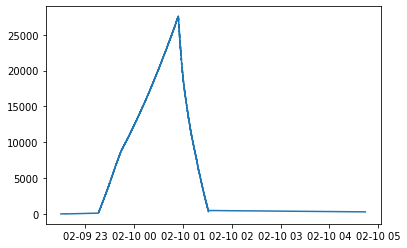

In [79]:
sonde_time = data[:,0] # get the datetime from the ndarray
alt = data[:,1] # get the altitude from the ndarray


plt.plot(sonde_time, alt)
plt.show()

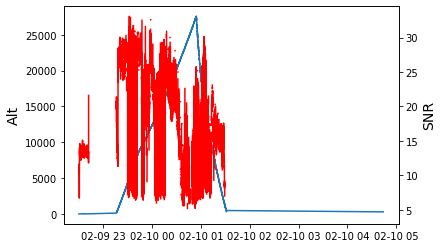

In [80]:
# Plot SNR along side

sonde_time = data[:,0] # get the datetime from the ndarray
alt = data[:,1] # get the altitude from the ndarray
snr = data[:,2] # get the altitude from the ndarray

fig,ax = plt.subplots()

ax.plot(sonde_time, alt) # plot altitude on the first axis
ax.set_ylabel("Alt",fontsize=14)

ax2=ax.twinx() # get a second axis
ax2.set_ylabel("SNR",fontsize=14)
ax2.plot(sonde_time, snr, color="red")


plt.show()